In [5]:
# ### 주택가격 예측
# - 아이오아주 에임스 지역에서 2006년 부터 2010년까지 거래된 실제 부동산 판매 기록
# - 주거 유형, 차고, 자재 및 환경 등 80개의 서로 다른 속성을 이용해 집의 가격을 예측
# - 속성에 대한 상세 설명 : https://jse.amstat.org/v19n3/decock/DataDocumentation.txt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

df = pd.read_csv('house_train.csv')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


이 데이터셋은 'AmesHousing.txt'라는 이름으로, 아이오와 주 에임즈시에서 2006년부터 2010년까지 개별 주거용 부동산의 평가 가치를 계산하는 데 사용된 에임즈 평가사무소의 정보를 담고 있습니다. 총 2930개의 관찰 데이터와 82개의 변수가 포함되어 있습니다. 이 데이터에는 주거용 부동산 판매와 관련된 다양한 유형의 정보가 포함되어 있으며, 이는 주택 구매자가 구매 전에 알고 싶어하는 일반적인 정보와 유사합니다. 변수들은 명목, 순서, 이산, 연속 변수로 구분되며, 주택의 위치, 크기, 스타일, 품질 등 다양한 특성을 나타냅니다.

데이터 파일에는 23개의 명목 변수, 23개의 순서 변수, 14개의 이산 변수, 20개의 연속 변수 및 2개의 추가 관찰 식별자가 포함되어 있습니다. 이들 변수는 주거용 부동산의 다양한 특성을 나타내며, 예를 들어 주택 스타일, 주택의 전반적인 품질 및 상태, 건축 연도, 지붕 스타일, 외부 재료, 난방 시스템의 품질, 주차장 유형, 부지의 크기 등을 포함합니다.

이 데이터셋은 회귀 분석 과정의 종강 프로젝트를 위해 구성되었으며, 학생들에게 주어지기 전에 4000 평방피트 이상인 주택을 제거하는 것이 권장됩니다. 이는 실제 시장 가치를 대표하지 않을 수 있는 특이한 관찰 결과를 제거하기 위함입니다. 데이터를 활용하는 데 있어 주의해야 할 점은 이상치 처리, 가정 위반, 예측 모델과 통계적 추론 사이의 차이점 등에 대한 토론의 기회를 제공한다는 것입니다.

In [6]:
df.SaleType.value_counts()

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64

이 데이터를 보면 'SaleType'이라는 열에 각각의 판매 유형이 얼마나 자주 나타났는지 알 수 있어요. 각 숫자는 그 판매 유형이 몇 번 나타났는지를 나타내죠.

- **WD** (Warranty Deed - Conventional): 1267번 나타났어요. 이게 가장 많이 사용된 판매 유형이에요.
- **New**: 122번 나타났어요. 새 집 판매를 의미해요.
- **COD** (Court Officer Deed/Estate): 43번 나타났어요. 법원 명령이나 유산으로 인한 판매일 수 있어요.
- **ConLD** (Contract Low Down): 9번 나타났어요. 낮은 초기 비용의 계약을 의미해요.
- **ConLI** (Contract Low Interest): 5번 나타났어요. 낮은 이자율의 계약을 의미해요.
- **ConLw** (Contract Low Down payment and low interest): 5번 나타났어요. 낮은 초기 비용과 낮은 이자율의 계약을 의미해요.
- **CWD** (Warranty Deed - Cash): 4번 나타났어요. 현금으로 판매하는 것을 의미해요.
- **Oth**: 3번 나타났어요. 다른, 일반적이지 않은 판매 유형을 의미해요.
- **Con** (Contract 15% Down payment regular terms): 2번 나타났어요. 15% 초기 비용을 내는 일반 계약을 의미해요.

이 정보를 통해 대부분의 집들이 'WD' 방식으로 팔렸고, 그 다음으로는 'New' 방식으로 새 집이 팔렸다는 것을 알 수 있어요. 다른 판매 유형들은 비교적 드물게 사용되었어요.

In [7]:
#결측치 처리
#속성별로 결측치가 몇개인지 확인

df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

이 목록에 있는 특성들은 부동산 데이터셋의 일부로 보입니다. 각각의 특성은 주택과 관련된 다양한 요소들을 나타냅니다:

1. **PoolQC**: 수영장의 품질을 나타냅니다.
2. **MiscFeature**: 다른 범주에 포함되지 않는 기타 특징(예: 테니스장, 엘리베이터 등)을 나타냅니다.
3. **Alley**: 주택이 골목길에 접근할 수 있는지 여부를 나타냅니다.
4. **Fence**: 울타리의 품질을 나타냅니다.
5. **MasVnrType**: 집 외부에 사용된 벽돌 베니어(벽 장식)의 유형을 나타냅니다.
6. **FireplaceQu**: 벽난로의 품질을 나타냅니다.
7. **LotFrontage**: 부동산이 길과 접한 면적의 길이(피트 단위)를 나타냅니다.
8. **GarageYrBlt**: 차고가 건설된 연도를 나타냅니다.
9. **GarageCond**: 차고의 상태를 나타냅니다.
10. **GarageType**: 차고의 유형을 나타냅니다 (예: 붙어있는, 분리된 등).
11. **GarageFinish**: 차고 내부의 마감 상태를 나타냅니다.
12. **GarageQual**: 차고의 품질을 나타냅니다.
13. **BsmtFinType2**: 지하실의 두 번째 마감 영역의 품질을 나타냅니다.
14. **BsmtExposure**: 지하실의 노출 정도를 나타냅니다 (예: 외부에 대한 접근성).
15. **BsmtQual**: 지하실의 높이와 전반적인 품질을 나타냅니다.
16. **BsmtCond**: 지하실의 일반적인 상태를 나타냅니다.
17. **BsmtFinType1**: 지하실의 첫 번째 마감 영역의 품질을 나타냅니다.
18. **MasVnrArea**: 벽돌 베니어의 면적(제곱피트)을 나타냅니다.
19. **Electrical**: 주택의 전기 시스템 유형을 나타냅니다.
20. **Id**: 데이터셋 내의 개별 주택을 식별하는 고유 번호입니다.

각 특성은 주택의 다양한 부분을 설명하며, 부동산 평가나 구매 결정에 중요한 정보를 제공합니다.

In [8]:
#카테고리형 변수를 0과 1로 이루어진 변수로 바꾸기   원핫 인코딩 한다는 것 칼럼이 81개에서 289개로 늘어남
df = pd.get_dummies(df)    

#결측치를 전체 칼럼의 평균으로 대체하여 채워주기
df = df.fillna(df.mean())

#업데이트된 데이터프레임으로 출력
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,True,False,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,True,False,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,True,False,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,True,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,True,False,False,False,False,True,False


In [9]:
#속성별 관련도 추출하기
#데이터 사이의 상관 관계를 저장

df_corr = df.corr()

#집값과 관련이 큰 것부터 순서대로 저장
df_corr_sort=df_corr.sort_values('SalePrice', ascending=False)

#집 값과 관련도가 가장 큰 10개의 속성 출력
df_corr_sort['SalePrice'].head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

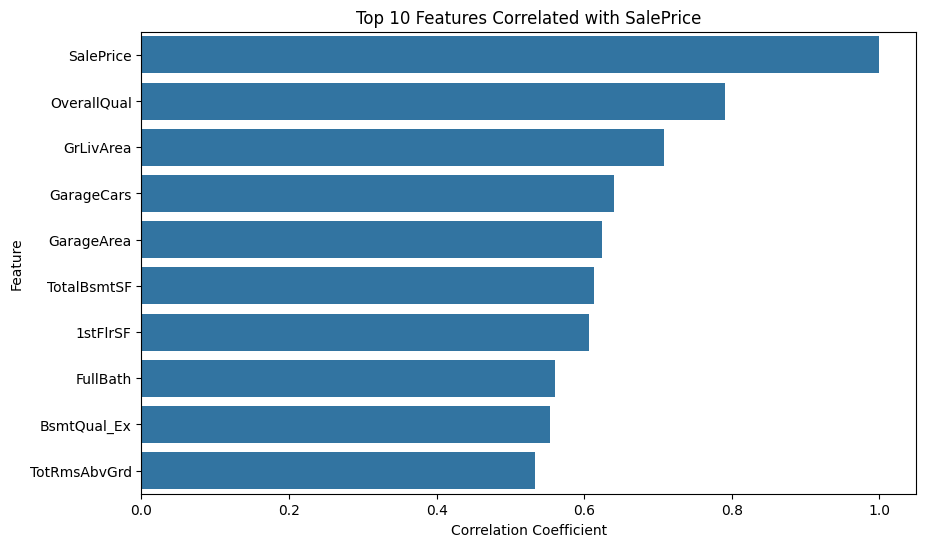

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터를 시각화하기 위해 DataFrame 생성
# 상위 10개의 특성만 포함하기 위해 head(10) 사용
df_example = pd.DataFrame(list(df_corr_sort['SalePrice'].items()), columns=['Feature', 'Correlation with SalePrice']).head(10)

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="Correlation with SalePrice", y="Feature", data=df_example.sort_values("Correlation with SalePrice", ascending=False))

plt.title('Top 10 Features Correlated with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

In [15]:
#주택 가격 예측
#집 값을 제외한 나머지 열을 저장
cols_train=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X_train_pre = df[cols_train]

y = df['SalePrice'].values
X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size=0.2, shuffle=True, random_state=123)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

model.summary()

#모델 실행
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=32)

test_loss = model.evaluate(X_test, y_test)

from math import sqrt

rmse = sqrt(test_loss)

print(f'MSE: {test_loss}')
print(f'RMSE: {rmse}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                60        
                                                                 
 dense_9 (Dense)             (None, 30)                330       
                                                                 
 dense_10 (Dense)            (None, 40)                1240      
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                                 
Total params: 1671 (6.53 KB)
Trainable params: 1671 (6.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 1s 5ms/step - loss: 38867619840.0000 - val_loss: 38699433984.0000
Epoch 2/200
28/28 [================

모델 요약: model.summary()는 모델의 구조를 요약하여 보여줍니다. 총 1671개의 파라미터가 있으며, 모든 파라미터가 훈련 가능합니다.

모델 컴파일: 모델을 컴파일하고 'adam' 최적화기와 평균 제곱 오차(mean squared error) 손실 함수를 사용합니다.

모델 훈련: model.fit을 사용하여 모델을 훈련합니다. 훈련 과정에서는 200번의 에포크 동안 훈련 데이터에 대해 학습하고, validation_split=0.25로 설정하여 훈련 데이터의 25%를 검증 데이터로 사용합니다.

평가: 훈련이 끝난 후, 테스트 데이터 세트에서 모델을 평가합니다. 테스트 손실은 약 1,806,117,120입니다. 이 값은 평균 제곱 오차로, 모델이 예측한 주택 가격과 실제 가격 사이의 차이의 제곱을 평균낸 값입니다. 이 손실 값은 모델의 성능을 평가하는 지표로 사용됩니다.

경고 메시지들은 TensorFlow의 이전 버전에 관련된 내용으로, 현재 사용 중인 코드에 영향을 미치지 않는다는 점을 나타냅니다.

마지막으로, 모델의 테스트 손실은 모델이 얼마나 잘 예측하는지에 대한 지표입니다. 손실 값이 낮을수록 모델의 성능이 좋다는 것을 의미합니다. 그러나 이 값이 실제로 어느 정도의 오차를 나타내는지 이해하려면, 손실 값을 원래 주택 가격의 스케일로 해석해야 합니다. 예를 들어, 평균 주택 가격과 비교하여 평균 손실 값이 어느 정도인지, 또는 손실 값을 주택 가격의 범위와 비교해야 실제 성능을 평가할 수 있습니다.

In [16]:
#만들어진 모델로 실제 예측해보기

#예측값과 실제 값, 실행번호가 들어갈 리스트 
real_prices = []
pred_prices = []
X_num = []

#25개의 샘플을 뽑아 실제 값, 예측 값을 출력해 보기

n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(25):
    real = y_test[i]
    prediction = Y_prediction[i]

    print(f"실행 번호: {n_iter}, 실제가격: {round(real)}, 예상가격: {round(prediction)}")
    real_prices.append(real)
    pred_prices.append(prediction)
    n_iter = n_iter + 1
    X_num.append(n_iter)

    

10/10 [==============================] - 0s 860us/step
실행 번호: 0, 실제가격: 222500, 예상가격: 197240
실행 번호: 1, 실제가격: 87000, 예상가격: 229462
실행 번호: 2, 실제가격: 130000, 예상가격: 180922
실행 번호: 3, 실제가격: 274300, 예상가격: 229009
실행 번호: 4, 실제가격: 140000, 예상가격: 159734
실행 번호: 5, 실제가격: 259000, 예상가격: 230957
실행 번호: 6, 실제가격: 309000, 예상가격: 258575
실행 번호: 7, 실제가격: 127500, 예상가격: 102913
실행 번호: 8, 실제가격: 155000, 예상가격: 172708
실행 번호: 9, 실제가격: 147000, 예상가격: 119650
실행 번호: 10, 실제가격: 159000, 예상가격: 170329
실행 번호: 11, 실제가격: 220000, 예상가격: 200609
실행 번호: 12, 실제가격: 140000, 예상가격: 131136
실행 번호: 13, 실제가격: 108000, 예상가격: 133384
실행 번호: 14, 실제가격: 260000, 예상가격: 215754
실행 번호: 15, 실제가격: 207500, 예상가격: 198027
실행 번호: 16, 실제가격: 115000, 예상가격: 124711
실행 번호: 17, 실제가격: 325624, 예상가격: 281682
실행 번호: 18, 실제가격: 212000, 예상가격: 198689
실행 번호: 19, 실제가격: 167900, 예상가격: 171313
실행 번호: 20, 실제가격: 151000, 예상가격: 161970
실행 번호: 21, 실제가격: 162900, 예상가격: 186193
실행 번호: 22, 실제가격: 109500, 예상가격: 92513
실행 번호: 23, 실제가격: 143000, 예상가격: 145173
실행 번호: 24, 실제가격: 230000, 예상가격: 211196


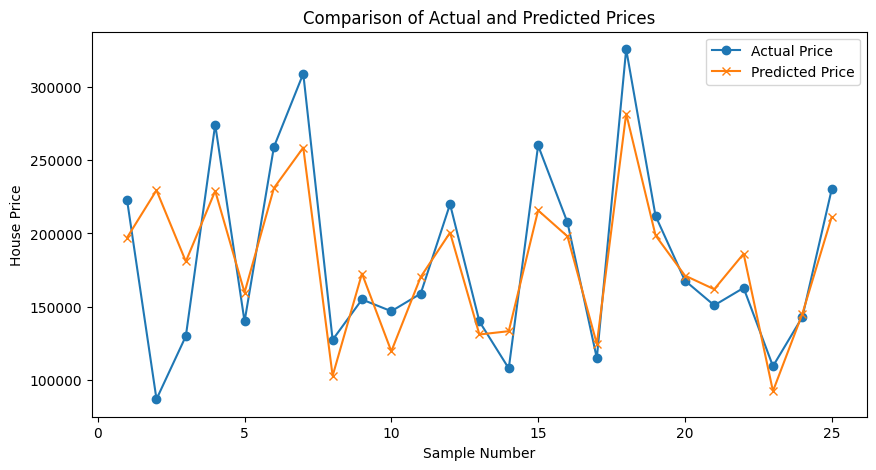

In [17]:
# 실제 가격과 예상 가격을 plot 그래프로 그리기 위한 코드입니다.
import matplotlib.pyplot as plt

# 이미 예측값과 실제 가격, 실행번호가 리스트에 저장되었다고 가정하고 진행합니다.
# 위의 코드를 기반으로 데이터를 생성하였습니다.
# 실제 데이터가 없으므로 가상의 데이터를 사용합니다.
X_num = list(range(1, 26))

# Plot 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(X_num, real_prices, label='Actual Price', marker='o')
plt.plot(X_num, pred_prices, label='Predicted Price', marker='x')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Number')
plt.ylabel('House Price')
plt.legend()
plt.show()


## 와인의 종류 예측하기 화이트 와인이냐 레드 와인이냐

- 속성 12개 : 주석산 농도, 아세트산 농도, 구연산 농도, 잔류 당분 농도, 염화나트륨 농도, 유리 아황산 농도, 총 아황산 농도, 밀도, pH, 황산칼륨 농도, 알코올 도수, 와인의 맛(0~10등급), 클래스(1:레드 와인, 0: 화이트 와인)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import random as python_random

tf.random.set_seed(12)
np.random.seed(12)
python_random.seed(12)

df = pd.read_csv('wine.csv', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### seed 설정
- NumPy의 무작위 작업에 대한 전역 제어를 위해 np.random.seed를 설정.
- np.random.seed(123)를 설정해도 스크립트를 실행할 때마다 정확히 동일한 학습 평가데이터 분할이 재현되도록 보장하려는 경우 train_test_split과 같은 scikit-learn 함수에 random_state를 지정.
- TensorFlow를 사용하는 경우 TensorFlow 작업에 tf.random.set_seed를 사용하며 신경망 레이어의 무작위 가중치 초기화, 훈련 프로세스의 임의성(예: , 이 특정 코드에 없는 드롭아웃 레이어를 사용하는 경우) 또는 임의성을 포함하는 기타 TensorFlow 작업을 사용하는 경우에 적용. 단순한 모델이나 특정 데이터 세트에 대해 훈련된 모델은 다양한 초기화에서 성능에 큰 변화를 나타내지 않을 수 있다
- Python 내장 random 모듈이 스크립트의 어느 곳에서나 사용되는 경우 해당 모듈의 시드를 설정. TensorFlow 작업 자체에 'python_random.seed(123)'를 직접 사용할 필요가 없지만 스크립트 시작 부분에 python_random.seed(123)를 설정하면 난수 생성을 위해 내장된 python random 모듈을 사용하는 모든 Python 작업에 영향을 미칠 수 있다.

In [24]:
#와인 속성을 X, 종류를 y

X = df.iloc[:, 0:12]
y = df.iloc[:, 12]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=14)

model = Sequential()
model.add(Dense(30, input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25, verbose=0)

score=model.evaluate(X_test, y_test)
print('accuracy:', score[1])

# 모델 저장 경로 설정
model_save_path = 'wine_model.keras'    #h5 파일은 레거시니깐 쓰지 마라고 경고문구 나옴

# 모델 저장
model.save(model_save_path)

# 저장 완료 메시지 출력
print(f"Model saved at:, {model_save_path}")


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 30)                390       
                                                                 
 dense_41 (Dense)            (None, 12)                372       
                                                                 
 dense_42 (Dense)            (None, 8)                 104       
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                                 
Total params: 875 (3.42 KB)
Trainable params: 875 (3.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
41/41 [==============================] - 0s 1ms/step - loss: 0.1716 - accuracy: 0.9346
accuracy: 0.9346153736114502
Model saved at:, wine_model.keras


`verbose` 매개변수는 학습 중에 콘솔에 출력되는 정보의 양을 조절합니다. `model.fit` 함수에 대한 `verbose` 매개변수는 다음과 같은 값을 가질 수 있습니다:

- `verbose=0`: 훈련 과정 중 어떠한 정보도 출력하지 않습니다.
- `verbose=1`: 훈련의 진행 상황에 대한 상세 정보를 바(bar)와 함께 실시간으로 출력합니다.
- `verbose=2`: 각 에포크(epoch)가 끝날 때마다 한 줄씩 출력합니다.

코드에서 `verbose=0`으로 설정하셨으므로, 훈련 과정 중 어떠한 정보도 콘솔에 출력되지 않을 것입니다. 이는 로그를 깨끗하게 유지하고 싶을 때나, 자동화된 프로세스에서 불필요한 출력을 방지하고 싶을 때 유용합니다.

In [25]:
from keras.models import load_model

# 저장된 모델의 경로
model_path = 'wine_model.keras'

# 저장된 모델 불러오기
model = load_model(model_path)

# 테스트 데이터로 모델의 성능 평가
score = model.evaluate(X_test, y_test, verbose=0)

# 정확도 출력
print(f"Test accuracy: {score[1]}")


Test accuracy: 0.9346153736114502


History 객체

- 신경망 훈련을 위해 Keras 또는 TensorFlow 사용 시 model.fit()과 같은 호출로 훈련 작업을 실행하면 History 객체가 반환. 이 객체에는 연속적인 에포크의 훈련 손실 값과 측정항목 값 기록뿐만 아니라 해당하는 경우 검증 손실 값과 검증 측정항목 값도 포함.

- 코드에서 얻은 History 객체의 내용을 보려면 훈련 과정 중에 기록된 측정항목이 포함된 사전인 history 속성에 액세스. 'history.history' 사전의 각 키는 훈련 중에 모니터링된 측정항목에 해당

In [20]:
history = model.fit(X_train, y_train, epochs=300, batch_size=500, verbose=0, validation_split=0.25)

In [21]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['val_loss'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.16996505856513977, 0.16887594759464264, 0.16814152896404266, 0.1672707349061966, 0.16642352938652039, 0.16497458517551422, 0.16449378430843353, 0.1633157581090927, 0.1628507375717163, 0.16133111715316772, 0.15993966162204742, 0.15890425443649292, 0.15865588188171387, 0.15809834003448486, 0.1564399003982544, 0.15516048669815063, 0.15535108745098114, 0.15321169793605804, 0.15195633471012115, 0.15058019757270813, 0.1500433087348938, 0.14852257072925568, 0.1480591595172882, 0.1463363617658615, 0.14586301147937775, 0.14718779921531677, 0.14709681272506714, 0.14274217188358307, 0.14294521510601044, 0.1424679011106491, 0.14115352928638458, 0.14006204903125763, 0.13755187392234802, 0.1378815770149231, 0.13485077023506165, 0.1345832645893097, 0.13385829329490662, 0.13207846879959106, 0.13113483786582947, 0.13025356829166412, 0.12920184433460236, 0.1281413584947586, 0.12725487351417542, 0.12623544037342072, 0.12652580440044403, 0.126

In [26]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.653503,0.367206,0.510479,0.792308
1,0.546436,0.785476,0.556396,0.806923
2,0.486377,0.805748,0.371733,0.833846
3,0.333156,0.864255,0.330750,0.886154
4,0.282946,0.890685,0.271032,0.892308


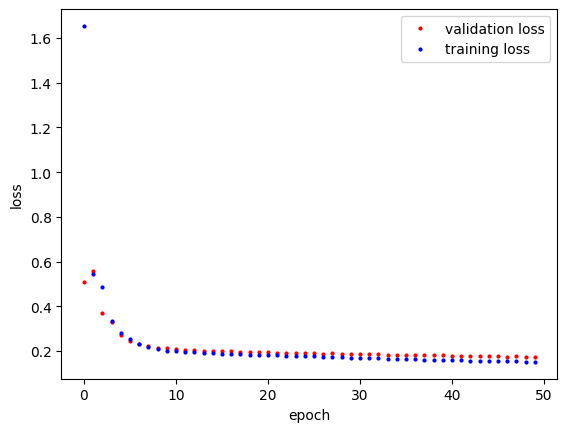

In [28]:
import matplotlib.pyplot as plt
import numpy as np

y_vloss=hist_df['val_loss']

y_loss=hist_df['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label="validation loss")
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label="training loss")

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


제공된 그래프는 신경망 모델의 훈련 및 검증 손실을 에포크별로 시각화한 것입니다. 여기서 몇 가지 관찰 사항이 있습니다:

- **손실 감소**: 그래프에서 볼 수 있듯이, 훈련 손실(파란색 점)과 검증 손실(빨간색 점) 모두 에포크가 진행됨에 따라 감소하고 있습니다. 이는 모델이 데이터에서 패턴을 학습하고 있으며, 손실 함수의 값이 최소화되어 가고 있음을 나타냅니다.

- **검증 손실과 훈련 손실 간의 관계**: 검증 손실이 훈련 손실과 비슷하거나 더 낮게 유지되고 있습니다. 이는 모델이 과적합되지 않고, 새로운 데이터에 대해서도 잘 일반화되고 있음을 의미합니다.

- **손실 수준**: 초기 에포크에서 손실이 급격히 감소하고 있으며, 이후 점차 안정화되는 양상을 보입니다. 약 10 에포크 이후에는 손실의 감소가 완만해지며, 이는 모델이 최적화 상태에 접근하고 있음을 나타냅니다.

- **에포크 수**: 50 에포크 동안 모델을 훈련시켰으며, 이 기간 동안 손실이 계속해서 감소하고 있습니다. 그러나 후반부에는 손실이 평탄화되어 추가적인 훈련이 모델 성능을 크게 향상시키지 않을 수 있습니다.

최적의 모델을 얻기 위해서는 훈련과 검증 손실이 안정화된 지점을 찾아 적절한 에포크에서 훈련을 중단하는 것이 중요합니다. 이를 위해 조기 종료(Early Stopping)와 같은 기법을 사용할 수 있습니다.

`validation loss`와 `training loss`는 모델이 학습하는 동안 계산되는 두 종류의 손실(loss) 값입니다. 이 두 값은 모델이 얼마나 잘 학습하고 있는지를 평가하는 데 사용됩니다.

- **Training Loss (훈련 손실)**: 이는 훈련 데이터셋에 대해 모델이 만드는 예측과 실제 목표 값 사이의 오차를 나타냅니다. 훈련 손실은 모델이 학습 과정에서 얼마나 잘 최적화되고 있는지를 보여주는 지표로, 낮을수록 모델이 훈련 데이터에 대해 더 정확한 예측을 하고 있음을 의미합니다.

- **Validation Loss (검증 손실)**: 이는 검증 데이터셋에 대해 모델이 만드는 예측과 실제 목표 값 사이의 오차를 나타냅니다. 검증 데이터셋은 모델이 학습 과정에서 본 적 없는 데이터로 구성되며, 검증 손실은 모델이 얼마나 잘 일반화되고 있는지를 평가하는 데 사용됩니다. 검증 손실이 낮을수록 모델이 새로운 데이터에 대해 더 정확한 예측을 할 가능성이 높습니다.

모델을 평가할 때, 훈련 손실과 검증 손실 모두 중요합니다. 훈련 손실이 낮지만 검증 손실이 높은 경우, 이는 모델이 훈련 데이터에 과적합(overfitting)되었을 수 있음을 나타냅니다. 즉, 모델이 훈련 데이터에는 잘 맞지만 새로운 데이터에 대해서는 잘 작동하지 않을 수 있습니다. 반면에 두 손실 값이 모두 낮고, 훈련 손실과 검증 손실 사이의 간격이 적을수록 모델이 잘 일반화되고 있다고 볼 수 있습니다.

[ callback ]

callbacks=[early_stopping_callback, checkpointer]

학습 과정 중에 특정 이벤트가 발생했을 때, 취할 행동을 정의.

- early_stopping_callback: 이 콜백은 모델의 성능이 더 이상 개선되지 않을 때 학습을 조기에 중단하도록 설정. 예를 들어, 검증 데이터에 대한 손실이 일정 기간 동안 개선되지 않으면 학습을 멈춘다. 이는 과적합을 방지하고 학습 시간을 단축시키는 데 도움이 된다.
- checkpointer: 이 콜백은 모델의 중간 학습 상태를 파일로 저장하여, 학습 과정에서 가장 좋은 모델을 보존할 수 있게 한다. 이를 통해 나중에 모델을 재사용하거나, 학습 과정이 끝난 후 최적의 모델 상태로 복원할 수 있다.

이 코드는 신경망 모델의 학습 과정을 세밀하게 제어하면서, 과적합을 방지하고, 학습 과정에서 모델의 최적 상태를 저장하는 방법을 보여준다.

In [40]:
#최적의 epoch 찾기

from keras.callbacks import EarlyStopping, ModelCheckpoint

# ModelCheckpoint 콜백 설정을 위한 저장 경로 업데이트
model_save_path = 'wine_train2.keras'

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 훈련 with EarlyStopping and ModelCheckpoint
history = model.fit(
    X_train, 
    y_train, 
    epochs=2000, 
    batch_size=500, 
    validation_split=0.25, 
    verbose=1,     
    callbacks=[early_stopping, checkpoint]
)

# 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])


print(f"Model saved at: {model_save_path}")


Epoch 1/2000
1/8 [==>...........................] - ETA: 4s - loss: 0.0279 - accuracy: 0.9860
Epoch 1: val_loss improved from inf to 0.13811, saving model to wine_train2.keras
8/8 [==============================] - 1s 23ms/step - loss: 0.0504 - accuracy: 0.9836 - val_loss: 0.1381 - val_accuracy: 0.9792
Epoch 2/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9860
Epoch 2: val_loss improved from 0.13811 to 0.12363, saving model to wine_train2.keras
8/8 [==============================] - 0s 8ms/step - loss: 0.0441 - accuracy: 0.9854 - val_loss: 0.1236 - val_accuracy: 0.9792
Epoch 3/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0503 - accuracy: 0.9840
Epoch 3: val_loss improved from 0.12363 to 0.11777, saving model to wine_train2.keras
8/8 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9879 - val_loss: 0.1178 - val_accuracy: 0.9838
Epoch 4/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accur

In [41]:
from keras.models import load_model

# 저장된 모델의 경로
model_path = 'wine_train2.keras'

# 저장된 모델 불러오기
loaded_model = load_model(model_path)

# 테스트 데이터로 모델의 성능 평가
score = loaded_model.evaluate(X_test, y_test, verbose=0)

# 정확도 출력
print(f"Test accuracy: {score[1]}")


Test accuracy: 0.9815384745597839


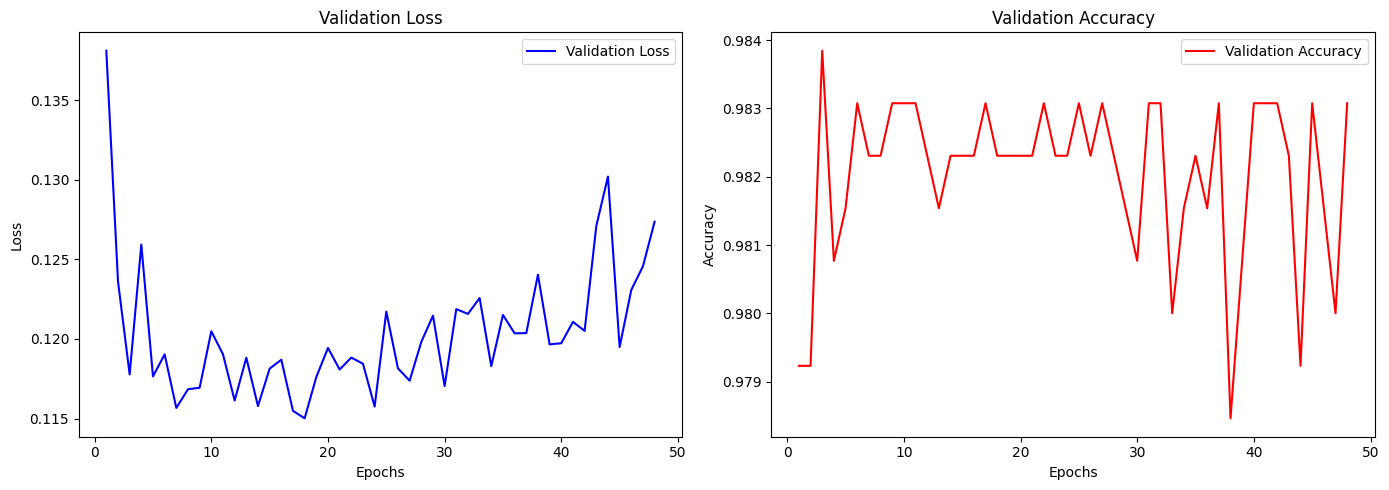

In [42]:
import matplotlib.pyplot as plt

# 시각화를 위한 데이터 추출
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 길이 설정
epochs = range(1, len(val_loss) + 1)

# 손실 그래프 그리기
plt.figure(figsize=(14, 5))

# 첫 번째 서브플롯 - 검증 손실
plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 두 번째 서브플롯 - 검증 정확도
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

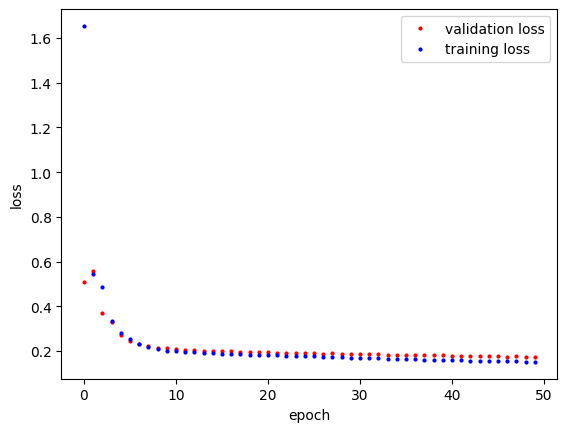

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y_vloss=hist_df['val_loss']

y_loss=hist_df['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label="validation loss")
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label="training loss")

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


검증 손실(`validation loss`) 값이 높다는 것은 모델이 검증 데이터셋에 대해 높은 오차를 가지고 있다는 의미입니다. 검증 데이터셋은 모델이 훈련 중에 보지 못한 데이터로, 모델이 얼마나 잘 일반화되고 있는지를 평가하는 데 사용됩니다. 따라서 검증 손실이 높다는 것은 다음과 같은 여러 가지를 의미할 수 있습니다:

1. **과적합(Overfitting)**: 모델이 훈련 데이터에는 잘 맞지만, 새로운 데이터에 대해서는 일반화하지 못하는 상태를 말합니다. 이 경우, 훈련 손실은 낮지만 검증 손실은 상대적으로 높게 나타날 수 있습니다.

2. **모델 복잡도**: 모델이 너무 복잡하고 많은 매개변수를 가지고 있어서 훈련 데이터에 과도하게 최적화되었을 수 있습니다.

3. **데이터 품질**: 검증 데이터셋에 문제가 있을 수 있습니다. 예를 들어, 훈련 데이터셋과 분포가 다르거나 잡음이 많은 데이터일 수 있습니다.

4. **적합하지 않은 모델 구조**: 사용한 모델이 문제를 해결하기에 적합하지 않을 수 있습니다. 예를 들어, 너무 단순하거나 주어진 문제를 해결하기 위한 적절한 특성을 학습하지 못할 수 있습니다.

5. **훈련 부족**: 모델이 충분히 훈련되지 않았을 수도 있습니다. 더 많은 에포크나 데이터가 필요할 수 있습니다.

6. **부적절한 훈련 과정**: 학습률이 너무 높거나 낮을 수 있고, 적절하지 않은 최적화 알고리즘이나 손실 함수를 사용했을 수 있습니다.

검증 손실을 줄이기 위해 모델의 복잡도를 조절하거나, 데이터 전처리를 개선하고, 다른 모델 구조를 시도하며, 조기 종료(Early Stopping)나 교차 검증과 같은 기법을 사용하는 것이 좋습니다.

훈련 손실(`training loss`)은 모델이 훈련 데이터셋에서 얼마나 잘 수행되는지를 나타내는 지표입니다. 이 값은 모델이 훈련 데이터에 대한 예측을 얼마나 정확하게 하는지를 측정합니다. 훈련 손실이 낮다는 것은 모델이 훈련 데이터에 대해 낮은 오차를 가진다는 것을 의미하며, 모델이 데이터에 대한 패턴을 잘 학습하고 있음을 나타냅니다.

훈련 손실이 낮다는 것은 일반적으로 좋은 징조입니다. 하지만 몇 가지 주의 사항이 있습니다:

1. **과적합(Overfitting)**: 모델이 훈련 데이터에 지나치게 최적화되어 새로운 데이터에 대해 일반화하지 못하는 상태를 말합니다. 이 경우, 훈련 손실은 매우 낮을 수 있지만, 검증 손실은 상대적으로 높게 나타날 수 있습니다.

2. **데이터 품질과 분포**: 훈련 데이터셋이 전체 데이터의 특성을 잘 대표하지 못하거나, 잡음이 많은 데이터일 경우, 훈련 손실이 낮더라도 실제 성능은 좋지 않을 수 있습니다.

3. **모델 복잡도**: 너무 복잡한 모델은 훈련 데이터에 과적합되기 쉽습니다. 즉, 훈련 데이터에 대해서는 잘 작동하지만, 일반화 성능이 떨어질 수 있습니다.

4. **훈련 부족**: 훈련 손실이 계속 감소하고 있지만 아직 충분히 낮지 않은 경우, 모델이 충분히 훈련되지 않았을 수 있으며, 더 많은 에포크가 필요할 수 있습니다.

이상적으로는 훈련 손실과 검증 손실 모두 낮고, 두 값 사이의 간격이 작아야 합니다. 이것은 모델이 훈련 데이터에 잘 맞으면서도 새로운 데이터에 대해 잘 일반화되고 있음을 나타냅니다.

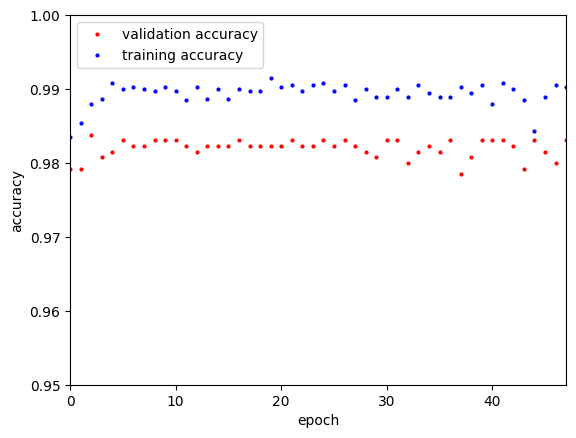

In [44]:
y_acc = history.history['accuracy']
y_val_acc = history.history['val_accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_val_acc, 'o', c='red', markersize=2, label='validation accuracy')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=2, label='training accuracy')

plt.legend(loc='upper left')
plt.xlim(0, len(y_acc)-1)
plt.ylim(0.95, 1.0)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

sigmoid 활성화 함수는 주로 이진 분류 문제에서 출력층에 사용됩니다. 이 함수는 출력을 0과 1 사이의 값으로 제한하기 때문에, 두 가지 범주 중 하나를 예측하는 데 적합합니다. 예를 들어, 이메일이 스팸인지 아닌지를 결정하는 경우와 같이 두 가지 선택지 중 하나를 예측할 때 유용합니다.

In [ ]:
#또 주택 가격 예측

# Q. house_train.csv 데이터 셋에 대하여 케라스를 이용하여 다음 사항을 수행하세요.
# - 데이터 파악하기
# - 결측치, 카테고리 변수 처리하기
#   - 속성별로 결측치가 몇 개인지 확인
#   - 카테고리형 변수를 0과 1로 이루어진 변수로 바꾸어 준다.
#   - 결측치를 전체 칼럼의 평균으로 대체하여 채워준다.
#   - 업데이트된 데이터프레임을 출력

# - 속성별 관련도 추출하기
#   - 데이터 사이의 상관 관계 파악
#   - 집 값과 관련도가 가장 큰 10개의 속성들을 출력
#   - 집 값과 관련도가 가장 높은 속성들을 추출해서 상관도 그래프 시각화(pair plot)


# - 주택 가격 예측 모델 생성 및 평가
#   - X, y 분리
#   - 전체의 80%를 학습셋으로, 20%를 테스트셋으로 지정 : sklearn.model_selection 모듈의 train_test_split 이용, random_state=123
#   - 모델 생성 :
#     - 첫번째 : 입력 은닉 공용 10개 유닛,
#     - 두번째 : 은닉 30개 유닛,
#     - 세번째 : 은닉 40개 유닛,
#     - 네번째 : 출력 1개 유닛

#   - 모델 컴파일 : optimizer ='adam', loss = 'mean_squared_error'
#   - 20회 이상 결과가 향상되지 않으면 자동으로 중단되게끔 설정.
#   - 학습 모델 저장 경로 설정. modelpath
#   - 최적화 모델을 업데이트하고 저장하도록 설정. checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)
#   - 학습 실행 관련 설정 : model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer])
#   - 테스트 데이터를 사용하여 모델 평가

# - 에포크별 손실값 변화 시각화
#   - 학습 과정에서의 손실값 추출
#   - 에포크(Epoch) 번호 생성
#   - 손실값 시각화
# - 25개의 샘플을 뽑아 실제 값, 예측 값 출력
# - 25개의 샘플을 뽑아 실제 값, 예측 값 시각화하여 비교



`ReLU` (Rectified Linear Unit) 활성화 함수는 신경망의 각 뉴런에 적용되는 비선형 함수입니다. 이 함수는 입력이 0보다 크면 그 입력을 그대로 출력하고, 0 이하이면 0을 출력합니다. 수학적으로는 `f(x) = max(0, x)`로 표현됩니다.

ReLU 활성화 함수의 주요 특징과 기능은 다음과 같습니다:

1. **비선형성**: ReLU는 비선형 함수입니다. 이 비선형성으로 인해 신경망은 복잡한 데이터에서 패턴을 학습할 수 있게 됩니다.

2. **계산 효율성**: ReLU의 계산이 매우 간단합니다 (단순히 0과 입력값을 비교). 이로 인해 신경망의 학습이 빨라질 수 있습니다.

3. **희소성(Sparsity)**: ReLU는 음수 입력에 대해 0을 출력합니다. 이는 신경망 내에서 0이 많이 발생하게 하여, 뉴런의 활성화가 더 희소해지는 효과를 가져옵니다. 희소한 표현은 모델이 데이터에서 중요한 특징을 더 잘 잡아내는 데 도움을 줄 수 있습니다.

4. **그라디언트 소실 문제 해소**: 이전에 많이 사용되던 `sigmoid`나 `tanh` 함수는 그라디언트(기울기)가 사라지는 (Vanishing Gradient) 문제를 일으킬 수 있습니다. 반면 ReLU는 이 문제를 어느 정도 해소해줍니다.

하지만 ReLU에도 단점이 있습니다. 0 이하의 값에 대해 항상 0을 출력하기 때문에, 일부 뉴런이 활성화되지 않을 수 있는 "죽은 ReLU" 문제가 발생할 수 있습니다. 이를 해결하기 위해 변형된 ReLU 함수들이 개발되었습니다 (예: Leaky ReLU, Parametric ReLU 등).

신경망에서 ReLU를 사용하는 주된 이유는 그 효율성과 비선형성 때문입니다. 이는 모델이 복잡한 문제를 효과적으로 학습하는 데 도움을 줍니다.

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64
Epoch 1/2000
 1/28 [>.............................] - ETA: 14s - loss: 44292366336.0000
Epoch 1: val_loss improved from inf to 38850138112.00000, saving model to house_train2.keras
28/28 [==============================] - 1s 7ms/step - loss: 38913077248.0000 - val_loss: 38850138112.0000
Epoch 2/2000
 1/28 [>.............................] - ETA: 0s - loss: 53875671040.0000
Epoch 2: val_loss improved from 38850138112.00000 to 38413832192.00000, saving model to house_train2.keras
28/28 [==============================] - 0s 3ms/step - loss: 38651437056.0000 - val_loss: 38413832192.0000
Epoch 3/2000
 1/28 [>.............................] - ETA: 0s - loss: 53629657088.0000
Epoch 3: val_loss improved from 3841383219

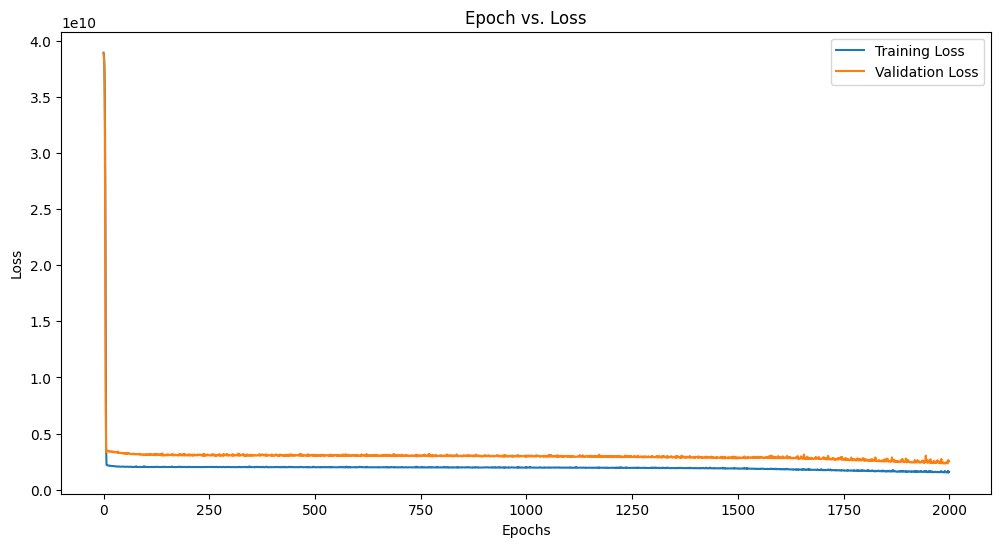

1/1 [==============================] - 0s 49ms/step
1. 실제 가격: 222500, 예측 가격: 216263.984375
2. 실제 가격: 87000, 예측 가격: 197831.71875
3. 실제 가격: 130000, 예측 가격: 212906.265625
4. 실제 가격: 274300, 예측 가격: 244349.578125
5. 실제 가격: 140000, 예측 가격: 161141.015625
6. 실제 가격: 259000, 예측 가격: 241456.578125
7. 실제 가격: 309000, 예측 가격: 280767.78125
8. 실제 가격: 127500, 예측 가격: 129659.8203125
9. 실제 가격: 155000, 예측 가격: 163921.0625
10. 실제 가격: 147000, 예측 가격: 128268.3359375
11. 실제 가격: 159000, 예측 가격: 164867.015625
12. 실제 가격: 220000, 예측 가격: 233945.75
13. 실제 가격: 140000, 예측 가격: 155447.265625
14. 실제 가격: 108000, 예측 가격: 132169.84375
15. 실제 가격: 260000, 예측 가격: 222374.3125
16. 실제 가격: 207500, 예측 가격: 185153.015625
17. 실제 가격: 115000, 예측 가격: 143760.890625
18. 실제 가격: 325624, 예측 가격: 296091.65625
19. 실제 가격: 212000, 예측 가격: 230835.625
20. 실제 가격: 167900, 예측 가격: 184021.046875
21. 실제 가격: 151000, 예측 가격: 170597.109375
22. 실제 가격: 162900, 예측 가격: 208561.796875
23. 실제 가격: 109500, 예측 가격: 129005.5703125
24. 실제 가격: 143000, 예측 가격: 178661.796875
25. 실제 가격:

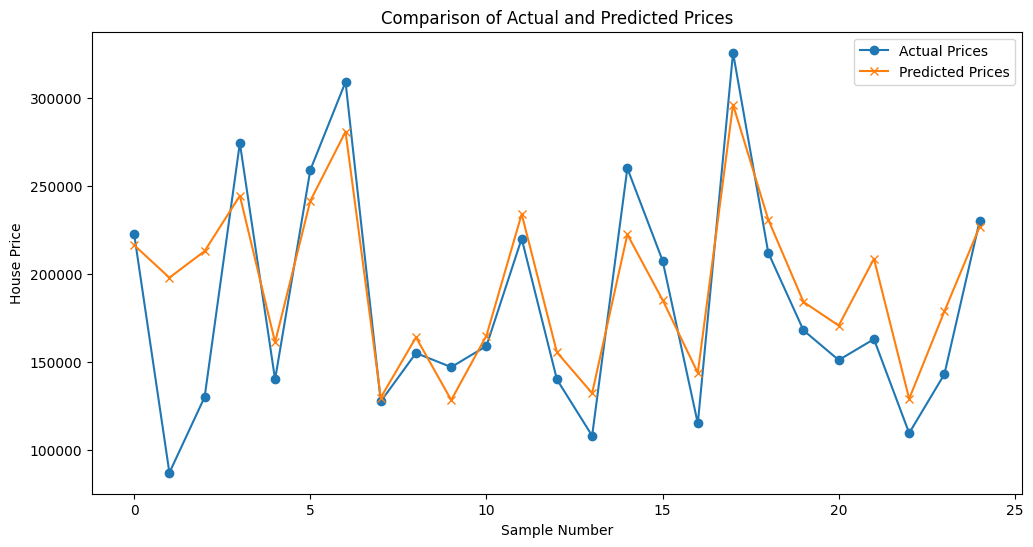

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터 로드 및 전처리
df = pd.read_csv('house_train.csv')

#원핫 인코딩
df = pd.get_dummies(df)

#null값 평균으로 대체
df = df.fillna(df.mean())

#속성별 관련도 추출하기
#데이터 사이의 상관 관계를 저장
df_corr = df.corr()

#집값과 관련이 큰 것부터 순서대로 저장
df_corr_sort=df_corr.sort_values('SalePrice', ascending=False)

#집 값과 관련도가 가장 큰 10개의 속성 출력
print(df_corr_sort['SalePrice'].head(10))


cols_train = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X = df[cols_train]
y = df['SalePrice'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)



# 모델 정의
model = Sequential([
    Dense(10, input_dim=X_train.shape[1], activation='relu'),  
    Dense(30, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping과 ModelCheckpoint 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
model_save_path = 'house_train2.keras'
checkpointer = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping, checkpointer])

# 모델 평가
test_loss = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(test_loss)
print(f'MSE: {test_loss}')
print(f'RMSE: {rmse}')

# 25개의 샘플에 대한 실제 값과 예측 값 출력 및 시각화
y_pred = model.predict(X_test[:25]).flatten()
for i in range(25):
    print(f"{i+1}. 실제 가격: {y_test[i]}, 예측 가격: {y_pred[i]}")


# 에포크별 손실값 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(y_test[:25], label='Actual Prices', marker='o')
plt.plot(y_pred, label='Predicted Prices', marker='x')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Number')
plt.ylabel('House Price')
plt.legend()
plt.show()


EarlyStopping을 사용하여 최적의 모델을 구하는 과정에서 성능이 더 나빠진 것처럼 보일 수 있습니다. 이는 여러 가지 요인에 의해 발생할 수 있으며, 다음과 같은 점들을 고려해볼 수 있습니다:

훈련 에포크 수: EarlyStopping을 사용한 경우, 모델은 지정된 patience 값에 도달할 때까지만 훈련됩니다. 이는 때때로 훈련이 충분히 이루어지지 않아 최적의 성능에 도달하지 못할 수 있습니다. 반면, 첫 번째 경우에서는 고정된 에포크 수(200 에포크) 동안 훈련되었습니다.

검증 데이터와 훈련 데이터의 차이: EarlyStopping은 검증 데이터셋의 성능을 기반으로 훈련을 중단합니다. 검증 데이터셋이 훈련 데이터셋과 다르게 분포되어 있거나, 특정 패턴을 적절히 반영하지 못하는 경우, 모델이 실제 테스트 데이터에 대해 최적화되지 않을 수 있습니다.

초기화와 랜덤성: 신경망의 초기 가중치는 랜덤하게 설정됩니다. 이로 인해 같은 코드를 여러 번 실행하더라도 다른 결과가 나올 수 있습니다. 또한, train_test_split 함수의 random_state 매개변수가 다르게 설정되면 데이터 분할이 달라져 결과가 변할 수 있습니다.

모델 구성과 하이퍼파라미터: 모델의 층 수, 뉴런 수, 활성화 함수 등의 구성과 하이퍼파라미터 설정에 따라 성능이 달라질 수 있습니다. 같은 구조를 사용하더라도, 훈련 과정에서의 미세한 차이가 결과에 영향을 미칠 수 있습니다.

손실 함수와 평가 메트릭: 손실 함수가 동일하더라도, 모델 평가 방법이나 사용된 데이터에 따라 결과가 달라질 수 있습니다.

훈련 과정에서 최적의 성능을 달성하기 위해서는 여러 하이퍼파라미터를 실험적으로 조정해보고, 데이터의 품질을 검토하며, 필요한 경우 모델 구조를 변경하는 것이 좋습니다. EarlyStopping의 patience 값을 조절하거나, 다른 검증 데이터셋을 사용해보는 것도 한 방법입니다.